Visualizing sleep with DBSCAN 
====================
This notebook visualizes sleep clusters using DBSCAN  from the scikit-learn library.

Use of DBSCAN
-----------------------
DBSCAN is used to identify clusters of sleep periods in the data.

1. Get Series of start-sleep and end-sleep timings in radian from *get_x_from_df()*. In This method, time in the format of _HH:MM_ is converted into radian using the _convert_to_radian()_ method.

2. Create a new dataframe containing the radian values of start-sleep and end-sleep from (1)

3. Calculate the eps and minPts – parameters used for DBSCAN

4. Create a pairwise distance matrix using from the dataframe in (2)

5. Call the _dbscan()_ method with the following parameters: eps, min_pts, X. eps and minPts are calculated in (3) and X is your pairwise distance matrix. Metric has been set to 'precomputed' as the pairwise distance matrix has been generated from (4)

This process will return you the following variables: *labels_, components_, core_sample_indices_*. *labels_* refer to the cluster label of each data point, i.e which cluster do they belong to. Values can be from 0 to n where n refers to the total number of clusters. Noise points are indicated with -1.


<span style="color:red">NOTE: here we choose the EPS as 1 hour, and the minPts as half of the data sample day</span>.


In [48]:
%matplotlib inline
###########################################IMPRORTS#########################################
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from math import pi,sqrt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import DistanceMetric
#import eps_min_pts as eps_And_MinPts
#import helper_adl as h
from matplotlib.backends.backend_pdf import PdfPages
###########################################IMPRORTS#########################################




In [49]:
# To return value in mins / total mins in one day
def to_mins(x):
    x = pd.Timestamp(x)
    year = x.year
    month =  x.month
    day = x.day
    return (x.value - pd.Timestamp(str(year)+'-'+str(month)+'-'+str(day)).value) / (60 * (10**9))
def to_date(x):
    x = pd.Timestamp(x)
    year = x.year
    month =  x.month
    day = x.day
    return pd.Timestamp(str(year)+'-'+str(month)+'-'+str(day))
# Helper method to convert values to radian
def convert_to_radian(x):
    return ((x / (24*60)) * 2 * pi)

# Returns a distance matrix (a numpy array)
def get_x_from_df(series):
    
    # Vectorizing to_mins and to_radian functions
    tmin = np.vectorize(to_mins)
    trad = np.vectorize(convert_to_radian)

    # Converting series of timestamp -> minutes / total minuites in a day -> radian
    input_rad = trad(tmin(series))
    #print("0, the raw array  is {}".format(input_rad))
    # Convert time to rad points   
    X = input_rad[None,:] - input_rad[:,None]
    print("the raw matix size is {}".format(X.size))
    print("the raw matix shape is {}".format(X.shape))
    #print("1, the raw matix  is {}".format(X))
    # Assign 'shortest distance to each point
    X[((X > pi) & (X <= (2*pi)))] = X[((X > pi) & (X <= (2*pi)))] -(2*pi)
    X[((X > (-2*pi)) & (X <= (-1*pi)))] = X[((X > (-2*pi)) & (X <= (-1*pi)))] + (2*pi) 
    X = abs(X)
    #print("2, the processed matix  is {}".format(X))
    return X,input_rad

# Returns output from sklearn DBSCAN method
def dbscan(eps, min_pts, X, metric='precomputed'):
    db = DBSCAN(eps, min_pts, metric)
    db.fit(X)
    return db.labels_, db.components_, db.core_sample_indices_

# Configures polar plot with 24 hour tick labels
def configure_polar_plot(axes):
    xticklabels = [str(x) for x in range (0,24)]
    axes.set_xticks(np.linspace(0,23,24,endpoint=True, dtype=np.int32) / 24 * (2 * np.pi))
    axes.set_xticklabels(xticklabels)
    axes.set_theta_zero_location('N')
    axes.set_theta_direction(-1)
    axes.set_ylim([0,1])
    axes.set_yticks([0.8,0.6])
    axes.set_yticklabels(['Sleep-Start', 'Sleep-End'])
    
    return axes

def plot_clusters(labels, rad_tseries, axes, ring):
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k,col in zip(unique_labels, colors):
        marker = '.'
        ms = 25.0
        rate = (1+k*0.1)*ring
        if k == -1:
            col='k'
            marker = 'x'
            ms = 8.0
            rate = ring

        indices_of_k, = np.where(labels == k)
        data = rad_tseries.take(indices_of_k)
        #print("ring is {},lable is {},data is {}".format(ring,k,data))
        
        axes.plot(data, [rate for x in data], color=col, marker=marker, linestyle='none', ms=ms, mec='k')

def get_clusters_info(label,rad_series,eps):
    info = ""
    for cluster_i in set(label):
        if cluster_i!=-1:
            print(cluster_i)
            indices_of_k = np.where(label == cluster_i)
            data = rad_series.take(indices_of_k)
            #print(data)
            data_min = np.min(data)
            #print(data_min)
            data_max = np.max(data)
            if data_max > pi and data_min<pi:
                data_min_ = np.min(data[data>pi])
                data_max_ = np.max(data[data<pi])
                if (data_min_ - data_max_) > eps:
                    data_max = np.max(data[data<pi])
                    data_min = np.min(data[data>pi])
            date_min = pd.to_datetime(data_min/2/pi*(24*60)*(60*10**9))
            date_max = pd.to_datetime(data_max/2/pi*(24*60)*(60*10**9))
            print("Cluster {}, start time:{}".format(cluster_i,date_min.strftime("%H:%M:%S")))
            print("Cluster {}, end time:{}".format(cluster_i,date_max.strftime("%H:%M:%S")))
            info += "\n Cluster {}, start time:{}, end time:{}".format(cluster_i,date_min.strftime("%H:%M:%S"),date_max.strftime("%H:%M:%S"))
            
    return info
# customize the distance calculations 
def customized_kmean_function(x,y):
    distance_temp = np.abs(x-y)
    distance_temp[distance_temp>pi]=2*pi - distance_temp[distance_temp>pi]
    return np.sqrt(np.sum(distance_temp**2))

In [50]:
def main_process(data_path,filename):
    
    S_ID = filename[11:15]
    print(S_ID)
    
    file_name = ''.join([data_path,'/',filename])
    
    
    # Get dataframe containing readings from sensor reading, exclude 
    df = pd.read_csv(file_name, delimiter=',', usecols=[x for x in range(0,5)],parse_dates=[1])
    column_names = list(df.columns.values)

    #print(df)

    start_day_list = pd.to_datetime(df['time_start']).apply(lambda x: x.strftime("%Y-%m-%d"))
    #print(df['time_start'])
    end_day_list = pd.to_datetime(df['time_end']).apply(lambda x: x.strftime("%Y-%m-%d"))
    #print(df['time_end'])
    #print("there are {} start date".format(len(sorted(set(start_day_list)))))
    #print("there are {} end date".format(len(sorted(set(end_day_list)))))
    min_pts = int(len(set(start_day_list) & set(end_day_list))/2)
    eps =2*pi/24
    #print("so we choose a half number {} as the minPts".format(min_pts))

    #print('time_start: eps: ', eps , ' minPts: ' , min_pts)
    TITLE_TEXT = "Start_Date_No:{}, End_Date_No:{}".format(len(sorted(set(start_day_list))),len(sorted(set(end_day_list))))
    TITLE_TEXT+= '\n eps: {},minPts'.format(eps ,min_pts)

    # X is a distance matrix.
    # Set 'X1' as sleep_start timings
    #print("\n========Calulate For start time==========\n")
    X1,X1_rad_series = get_x_from_df(df['time_start'])

    # sk-learn dbscan
    X1_label, X1_components, X1_csi = dbscan(eps, min_pts, X1)

    print(set(X1_label))

    INFO_TEXT_1 = "Start Time:" +get_clusters_info(X1_label,X1_rad_series,eps)


    X1_no_clusters = len(set(X1_label)) - (1 if -1 in X1_label else 0)
    #print('Number of clusters for start sleep time: ', X1_no_clusters )
    
    #pdf.attach_note('Number of clusters for start sleep time: ', X1_no_clusters)
    
    
    indices_of_X1_without_noise, = np.where(X1_label != -1)
    # print(indices_of_X1_without_noise)
    X1_no_noise = X1_rad_series[indices_of_X1_without_noise]
    #print("\n")

    #print("\n========Calulate For end time==========\n")
    # Set 'X2' as sleep_end timings
    X2,X2_rad_series = get_x_from_df(df['time_end'])
    #eps_X2, min_pts_X2 = eps_And_MinPts.knee_calculate_eps_minPts(X2)
    #print('time_end: eps: ', eps , ' minPts: ' , min_pts)
    # sk-learn dbscan
    X2_label, X2_components, X2_csi = dbscan(eps, min_pts, X2)

    #print(set(X2_label))


    INFO_TEXT_1+= "\n End Time:"+ get_clusters_info(X2_label,X2_rad_series,eps)

    X2_no_clusters = len(set(X2_label)) - (1 if -1 in X2_label else 0)
    #print('Number of clusters for end sleep time: ', X2_no_clusters )
    
    #pdf.attach_note('Number of clusters for end sleep time: ', X2_no_clusters )
        
    indices_of_X2_without_noise, = np.where(X2_label != -1)
    # print(indices_of_X2_without_noise)
    X2_no_noise = X2_rad_series[indices_of_X2_without_noise]
    #print("\n")
    # Create X3 DataFrame from X to test pairwise clusters
    # Data has already been optimized; Values are in radian, and shortest distances
    # have been assigned.
    X3 = pd.DataFrame()
    X3['sleep_start'] = X1_rad_series
    X3['sleep_end'] = X2_rad_series

    # Calculate eps and minPts dynamically.
    #print("X3 is {}".format(X3))
    distance = DistanceMetric.get_metric('euclidean')
    X3_dist_matrix = distance.pairwise(X3)
    #print("the old X3_dist_matrix is {}".format(X3_dist_matrix))

    distance = DistanceMetric.get_metric('pyfunc',func=customized_kmean_function)

    X3_dist_matrix = distance.pairwise(X3)
    #print("the new X3_dist_matrix is {}".format(X3_dist_matrix))
    #print("the X3 is {}".format(X3))
    #print("the X3_dist_matrix is {}".format(X3_dist_matrix))
    #eps_X3, min_pts_X3 = eps_And_MinPts.knee_calculate_eps_minPts(X3_dist_matrix)
    #print('duration: eps: ', eps , ' minPts: ' , min_pts)

    # sk-learn dbscan
    db3 = DBSCAN(eps, min_pts, metric='precomputed').fit(X3_dist_matrix)
    X3_label, X3_components, X3_csi = db3.labels_, db3.components_, db3.core_sample_indices_

    # Flatten X3 to a matrix to plot out values.
    #print("X3 is {}".format(X3))
    X3_matrix = X3.as_matrix()
    #print("X3_matrix is {}".format(X3_matrix))
    X3_matrix = X3_matrix.T
    #print("new X3_matrix is {}".format(X3_matrix))
    # - 1 if -1 exist in labels because -1 is used to denote noise
    X3_no_clusters = len(set(X3_label)) - (1 if -1 in X3_label else 0)
    #print('Number of clusters for X3(pairwise) cluster: ', X3_no_clusters )
    
    #INFO_TEXT_3+= "StartTime&EndTime: \n" get_clusters_info(X3_label,X_rad_series,eps)
    
    #pdf.attach_note('Number of clusters for X3(pairwise) cluster: ', X3_no_clusters )
    ##################PLOTTING####################
    # TODO: CLUSTER
    # TODO: CLUSTER
    fig = plt.figure(figsize=(25,25))
    #fig.text(0,0,"asdfffffffffffffj;ljf;sajfdsl;akfjsa;lfjkdsa;fldajksf;ldsakjfd;aslfjkdas;lfjsad;lfjasf;as")
    fig.suptitle(S_ID+"\n"+TITLE_TEXT, fontsize=20)
    # fig1 = plt.figure(figsize=(6,6))
    ax1 = configure_polar_plot(fig.add_subplot(121, projection='polar'))
    ax1.set_title("Clustering Result for Start_Time and End_Time (Separately)")
    ax1.set_xlabel(INFO_TEXT_1)
    # Plot clusters for start_time and end_time for sleep periods
    plot_clusters(X1_label, X1_rad_series, ax1, 0.8)
    plot_clusters(X2_label, X2_rad_series, ax1, 0.6)


    ax2 = configure_polar_plot(fig.add_subplot(122, projection='polar'))
    ax2.set_title("Clustering Result for Start_Time and End_Time")
    # Plot clusters of pairwise start_time and end_time for sleep periods
    plot_clusters(X3_label, X3_matrix[0], ax2, 0.8)
    plot_clusters(X3_label, X3_matrix[1], ax2, 0.6)


    #plt.show()

    print("Elasped Time: ", round(time.time() - time_now, 3), "seconds")



    fig.savefig(f[:-4]+".png")

sleep_2015_S001.csv
S001
the raw matix size is 693889
the raw matix shape is (833, 833)
{0, -1}
0
Cluster 0, start time:18:31:43
Cluster 0, end time:22:02:40
the raw matix size is 693889
the raw matix shape is (833, 833)
0
Cluster 0, start time:03:05:09
Cluster 0, end time:06:45:02
1
Cluster 1, start time:06:48:19
Cluster 1, end time:09:58:17
Elasped Time:  4.856 seconds


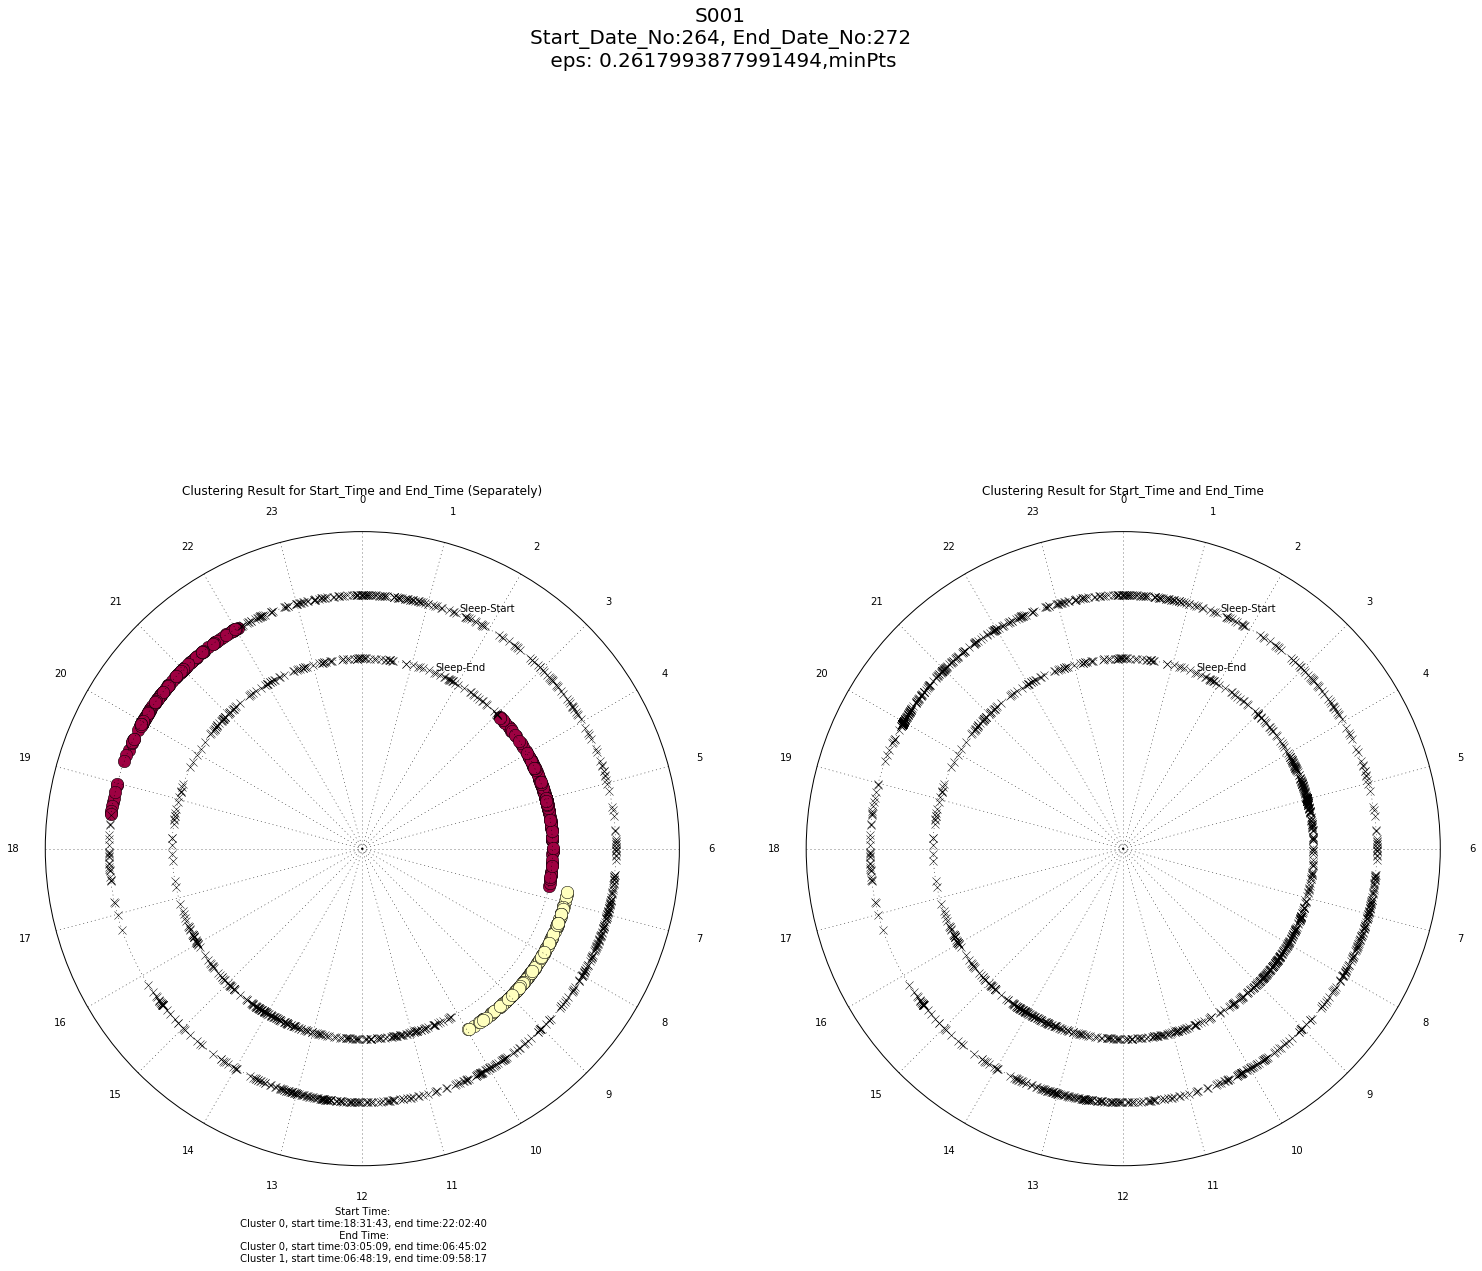

In [51]:

# Code
# Start timer:
time_now = time.time()

### Globals ###
data_path = '../Data/sleep/sleep_raw_2015'
# Perform clustering on files 1 to 10
# indexes = [str(x) for x in range(1,10)]



files = [f for f in listdir(data_path) if isfile(join(data_path, f))]

for f in files:
    print(f)
    main_process(data_path,f)


# remember to close the object to ensure writing multiple plots




## 